In [1]:
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import seaborn as sn
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

plt.style.use("ggplot")

# Replace SSB's wastewater workflow in TEOTIL3

Miljødirektoratet have tight deadlines for the Oslofjord modelling project. Unfortunately, SSB are not able to provide estimates of discharges from wastewater treatment plants for all parameters in time to meet these deadlines.

The aim of this notebook is to implement an alternative version of SSB's workflow, beginning with more basic datasets.

## 1. Default values per person

Where direct measurements are not available, SSB assumes default nutrient discharges per person per day and estimates nutrient inputs based on the number of people connected to each plant (or type of plant). The default values come from a [book published by Norsk Vann](https://va-kompetanse.no/butikk/laerebok-i-vann-og-avlopsteknikk/). See e-mail from Gisle received 27.03.2025 for a screenshot of the relevant page.

In [2]:
# Default person-specific discharges (g per person per day)
pers_dict = {
    "totn": 12,
    "totp": 1.8,
    "bof5": 60,
    "kof": 120,
    "ss": 70,
}

## 2. Small wastewater treatment plants (<50 p.e.)

As a starting point, SSB can provide estimates of the **number of people** connected to each type of small treatment plant in each kommune. The code in this section aims to:

 1. Recreate SSB's workflow for N and P using the **old** treatment efficiencies to check I can recreate SSB's original results.
    
 2. Update the workflow to use **new** treatment efficiencies recently published by NIBIO.
    
 3. Extend the workflow to include **BOF5** and **SS**.

### 2.1. Old and new treatment efficiencies

SSB's original workflow defines treatment efficiencies only for N and P. See Section 3.3.4 of [this report](https://niva.brage.unit.no/niva-xmlui/handle/11250/2985726) and the references therein for details.

A [recent report](https://nibio.brage.unit.no/nibio-xmlui/handle/11250/3183748) by NIBIO includes updated treatment efficiencies for N and P, as well as proposed efficiencies for BOF5 and SS. The new report suggests ideal treatment efficiencies for properly maintained facilities, but it also provides "reduction factors" by which the ideal efficiencies should be reduced to represent typical conditions (i.e. the real efficiency of normally maintained facilities of average age). Based on the new data, the expected mean efficiency is calculated as:

$$E_{mean} = E_{ideal} (1 - \frac{R}{100})$$

Where $E_{mean}$ is the expected true average efficiency (%); $E_{ideal}$ is the reference or "best case" efficiency for a well maintained facility (%); and $R$ is the efficiency reduction factor (%).

The old and new efficiencies for each "small" treatment type can be found in `treatment_efficiencies_small_wastewater.csv`.

In [3]:
# Read treatment efficiency data
eff_csv = "../../../data/treatment_efficiencies_small_wastewater.csv"
eff_df = pd.read_csv(eff_csv)
eff_df.head()

,ssb_code,ssb_desc,teotil_type,totn_eff_old_pct,totp_eff_old_pct,totn_eff_new_pct,totp_eff_new_pct,bof5_eff_new_pct,ss_eff_new_pct,totn_redfac_new_pct,totp_redfac_new_pct,bof5_redfac_new_pct,ss_redfac_new_pct
0,FASTBOURENS2,Urenset utslipp,Direkte utslipp,0,0,0,0,0,0,0,0,0,0
1,FASTBOSLAM2,Slamavskiller uten etterfiltrering,Slamavskiller,5,5,10,10,25,60,25,25,25,25
2,FASTBOINFILT2,Slamavskiller med infiltrasjon (stedegne masser),Infiltrasjonsanlegg,20,75,40,90,90,100,10,20,10,5
3,FASTBOSAND2,Slamavskiller med sandfilter (tilførte masser),Sandfilteranlegg,15,15,30,75,90,95,10,75,20,10
4,FASTBOBIO2,Minirenseanlegg - biologisk,Biologisk,10,15,30,60,90,80,10,20,10,20


### 2.2. Recreate old workflow for N and P

Checking I can correctly reproduce SSB's old workflow for N and P.

In [4]:
# Read SSB data. The data sent by Gisle in 2023 (for 2002 to 2022) is the last dataset
# based on the "old" treatment efficiencies, so use this for comparison
fpath = r"/home/jovyan/shared/common/teotil3/point_data/historic_data_delivered_2023/tmp_teotil_smaa_anlegg_2002_2022.sdv"
df = pd.read_csv(fpath, sep=";", encoding="cp1252")

for idx, row in eff_df.iterrows():
    site_type = row["ssb_code"]
    df[site_type] = df[site_type].fillna(0)
    for par in ["n", "p"]:
        # Get old treatment efficiency
        treat_eff = row[f"tot{par}_eff_old_pct"] / 100

        # Estimate discharge
        df[f"{par.upper()}_Est_{site_type}"] = (
            365 * df[site_type] * pers_dict[f"tot{par}"] * (1 - treat_eff) / 1000
        )
        df[f"{par.upper()}_{site_type}"] = df[f"{par.upper()}_{site_type}"].fillna(0)

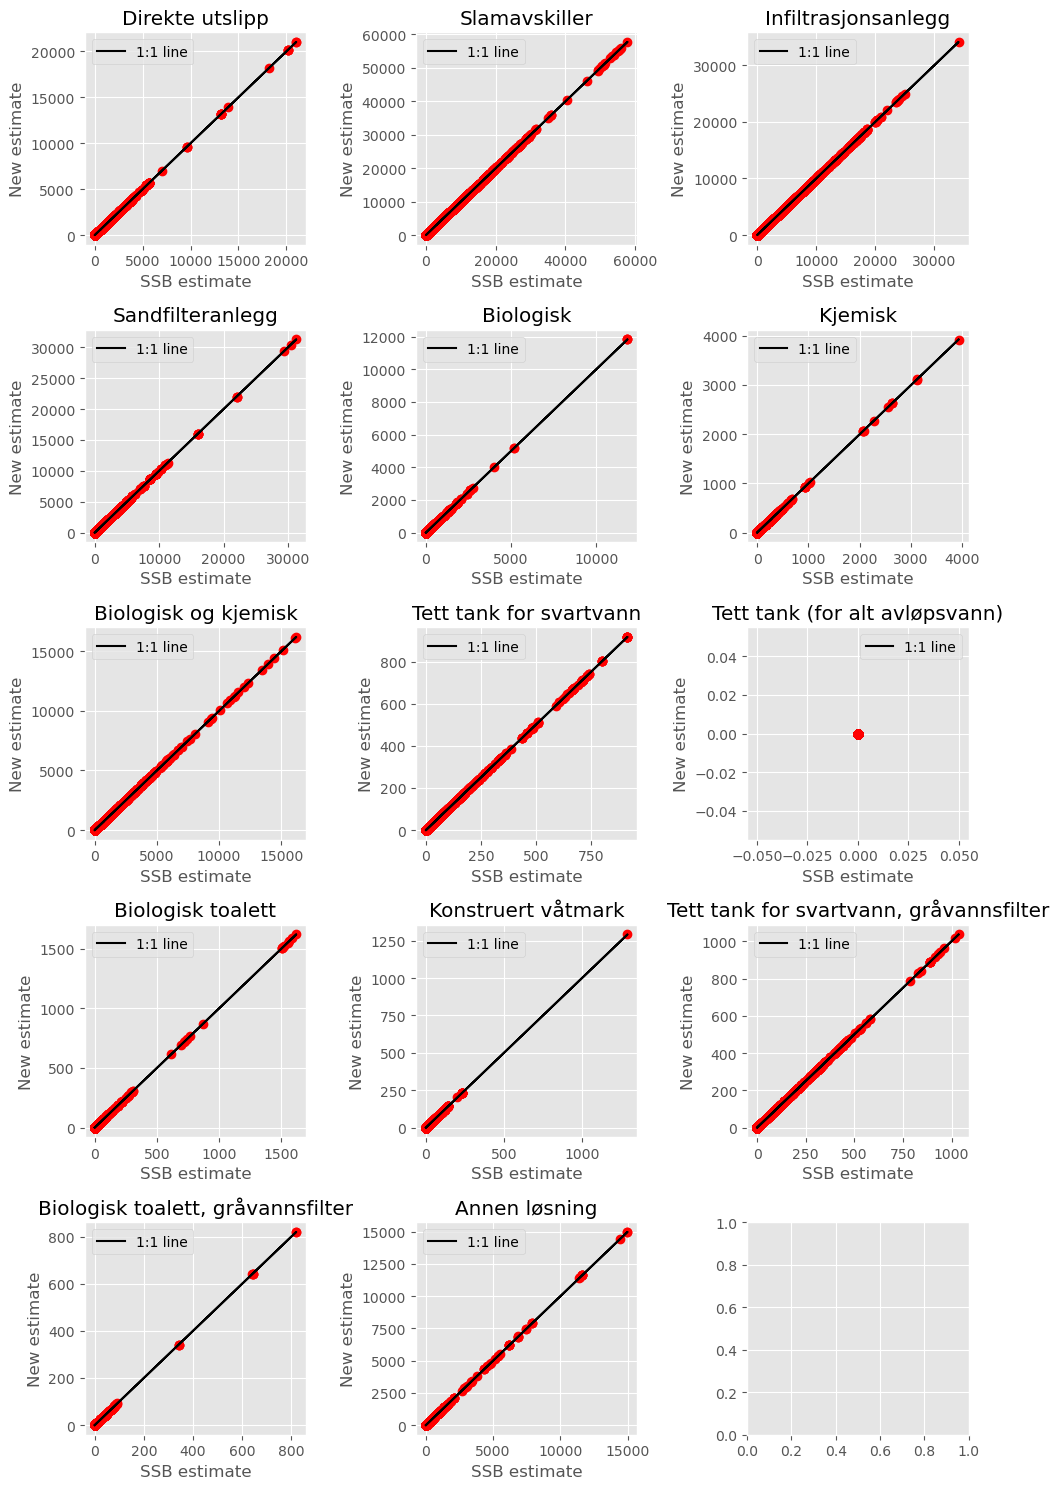

In [5]:
# Plot SSB values against new estimates
par = "n"

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10, 15))
axes = axes.flatten()

for idx, row in eff_df.iterrows():
    site_type = row["ssb_code"]
    teo_type = row["teotil_type"]
    axes[idx].plot(
        df[f"{par.upper()}_{site_type}"], df[f"{par.upper()}_Est_{site_type}"], "ro"
    )
    axes[idx].plot(
        df[f"{par.upper()}_{site_type}"],
        df[f"{par.upper()}_{site_type}"],
        "k-",
        label="1:1 line",
    )
    axes[idx].set_xlabel("SSB estimate")
    axes[idx].set_ylabel("New estimate")
    axes[idx].set_title(teo_type)
    axes[idx].legend()
plt.tight_layout()

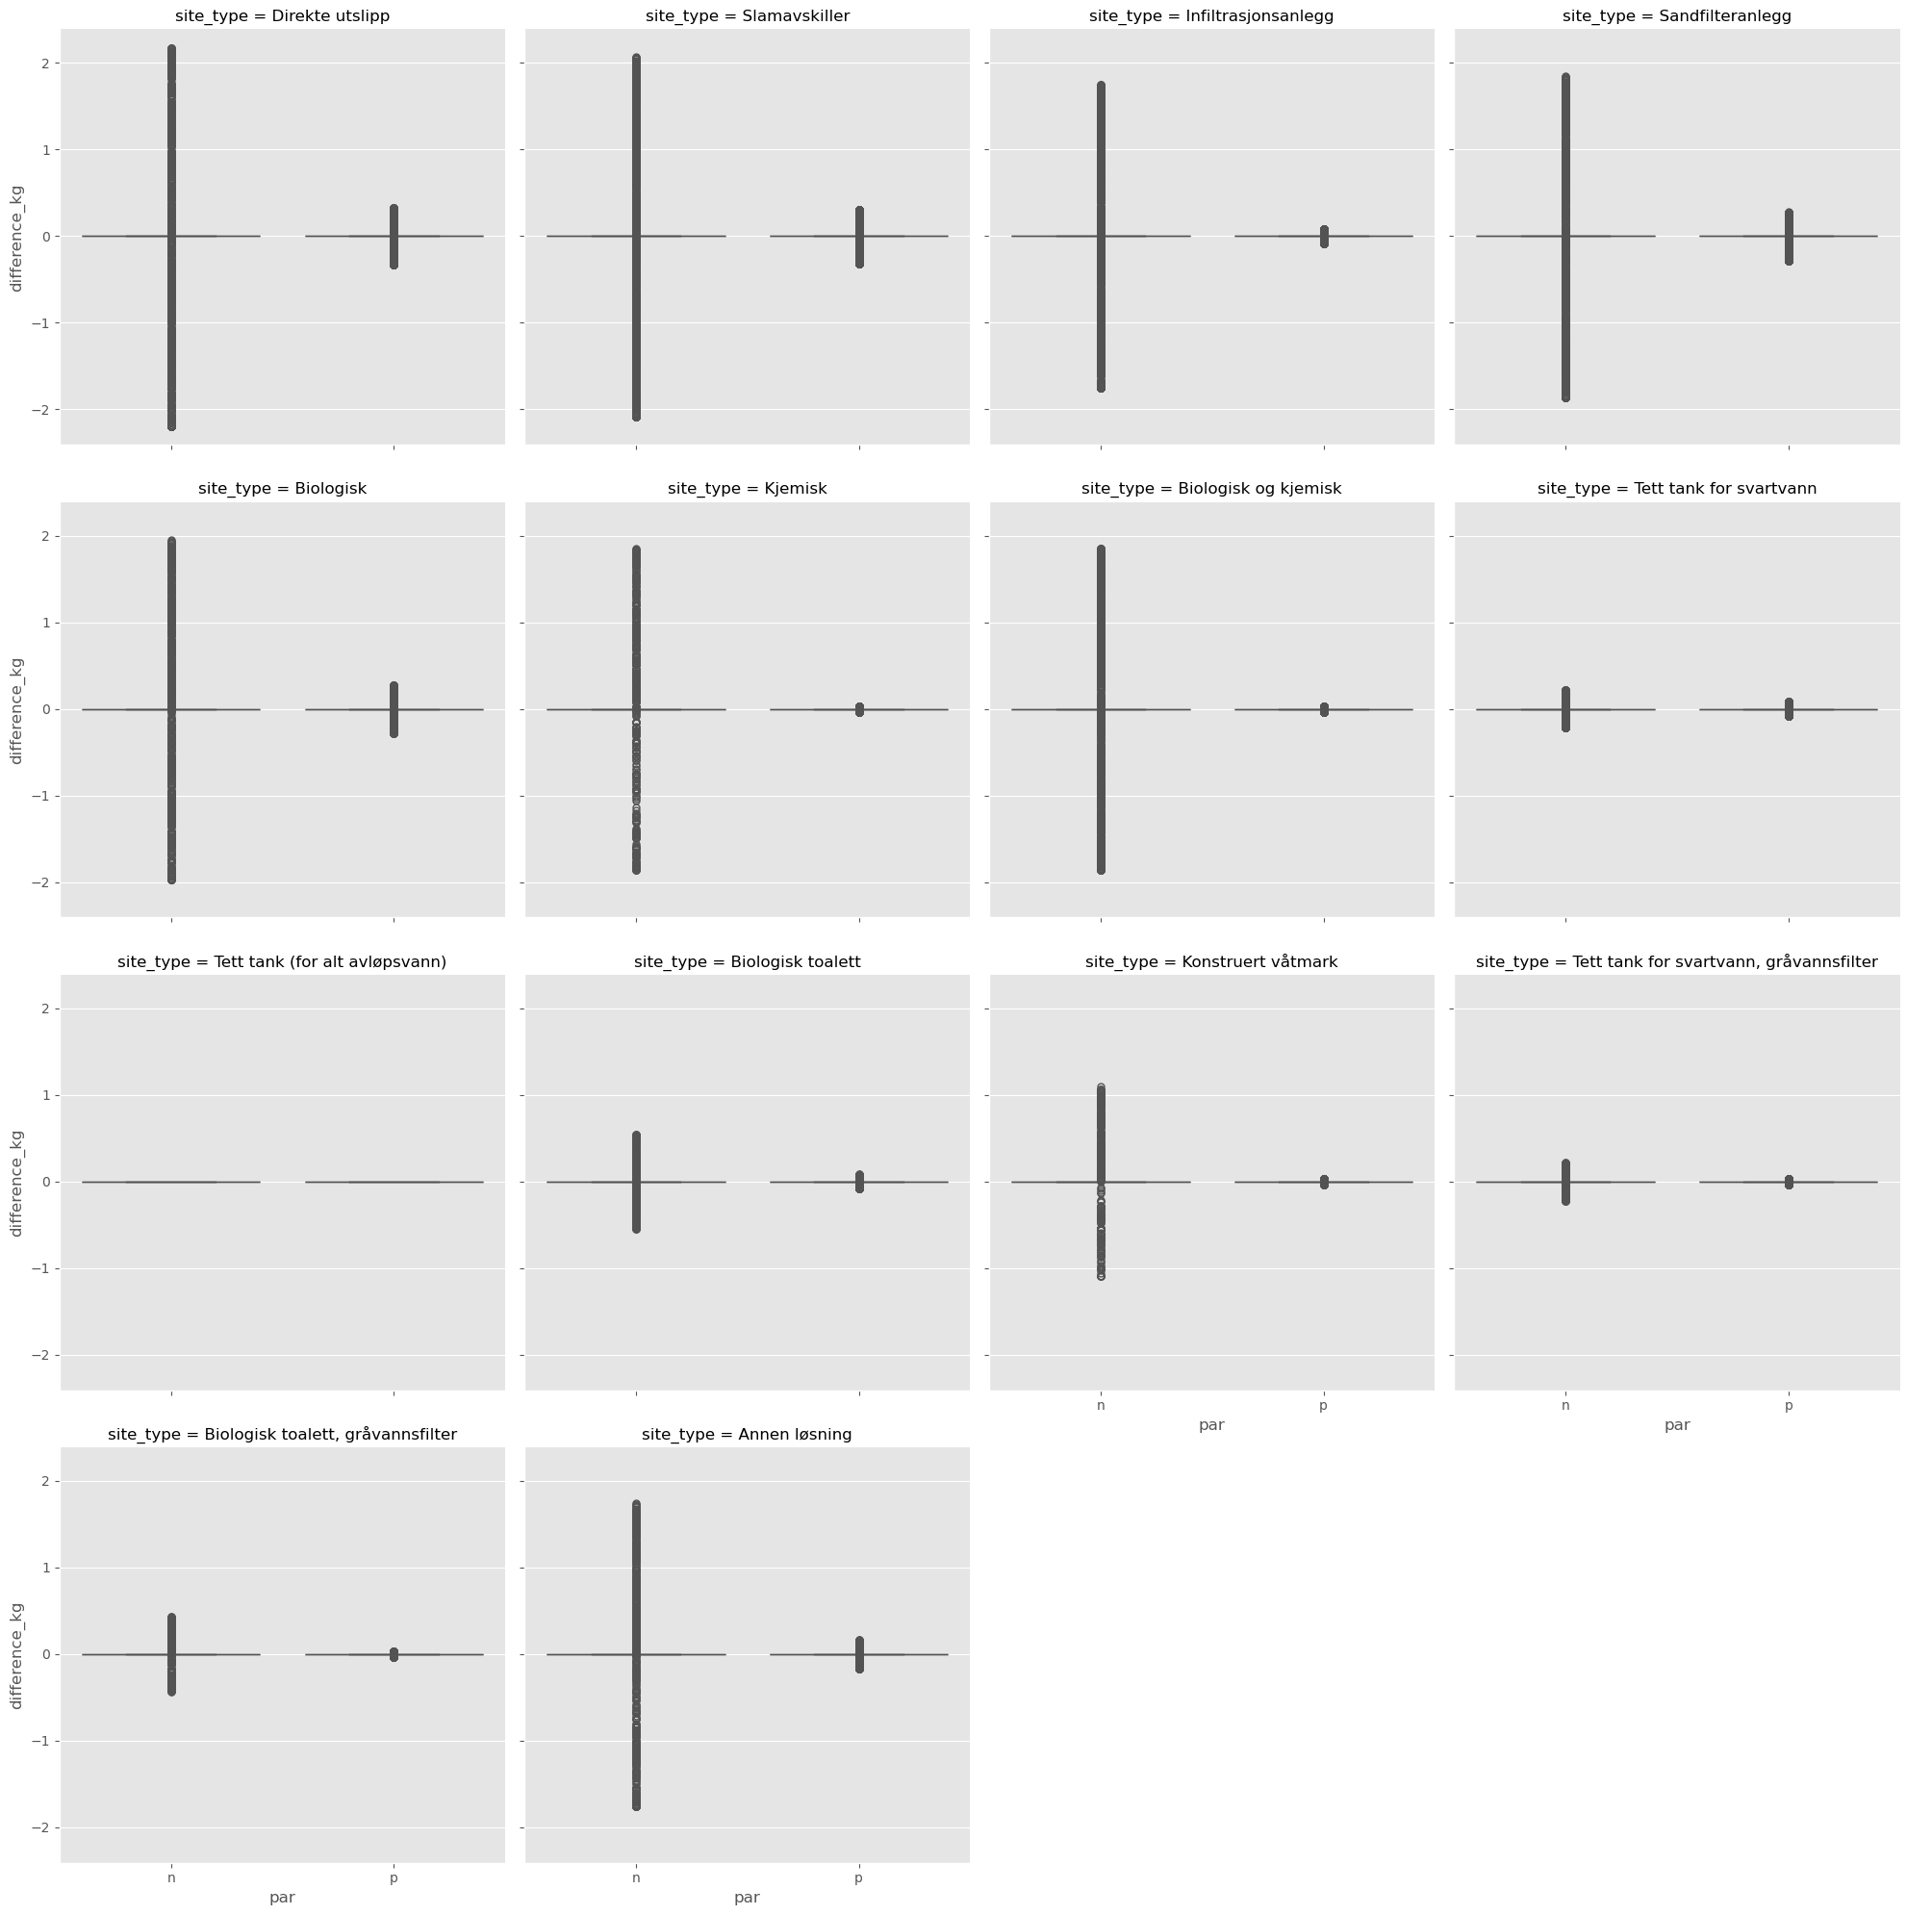

In [6]:
# Plot distribution of differences for each par
df_list = []
for idx, row in eff_df.iterrows():
    site_type = row["ssb_code"]
    teo_type = row["teotil_type"]
    for par in ["n", "p"]:
        # Difference between SSB estimates and new estimates
        diffs = pd.DataFrame(
            df[f"{par.upper()}_{site_type}"] - df[f"{par.upper()}_Est_{site_type}"]
        )
        diffs["par"] = par
        diffs["type"] = teo_type
        diffs.columns = ["difference_kg", "par", "site_type"]
        df_list.append(diffs)
diff_df = pd.concat(df_list, axis="rows")

# Boxplots of differences
sn.catplot(
    data=diff_df,
    x="par",
    y="difference_kg",
    col="site_type",
    col_wrap=4,
    kind="box",
)

The plots above show that my estimates for N and P discharges are identical to those from SSB in most cases, except for a small number of "outliers". However, even for these, differences for N are less than ±2 kg, and for P they're less than ±0.5 kg. In other words, the datasets are the same from a practical perspective.

### 2.3. Update N and P discharges and add BOF5 and SS

This section estimates kommune-level losses of N and P from each site type using the **new** treatment efficiencies from NIBIO (including a correction based on the new "reduction factors"). It also **adds BOF5 and SS** using the same methodology.

In [7]:
# Read latest SSB data. These calculations only use population estimates from SSB,
# so we can use the latest dataset
fpath = r"/home/jovyan/shared/common/teotil3/point_data/raw_data_delivered_2024/tmp_teotil_smaa_anlegg_2002_2023.sdv"
df = pd.read_csv(fpath, sep=";", encoding="cp1252")

for idx, row in eff_df.iterrows():
    site_type = row["ssb_code"]
    df[site_type] = df[site_type].fillna(0)
    for par, pers_contrib in pers_dict.items():
        if par == "kof":
            # Not relevant for small wastewater as NIBIO do not give factors for KOF
            continue

        # Estimate typical efficiency, allowing for reduction factors
        red_fac = row[f"{par}_redfac_new_pct"] / 100
        treat_eff = row[f"{par}_eff_new_pct"] * (1 - red_fac) / 100

        # Estimate discharge
        df[f"TEO3_{par.upper()}_{site_type}"] = (
            365 * df[site_type] * pers_contrib * (1 - treat_eff) / 1000
        )

# Just cols of interest
cols = ["KOMMUNE_NR", "KOMMUNE_NAVN", "aargang"] + [
    col for col in df.columns if col.startswith("TEO3_")
]
df = df[cols]
df.columns = [col.upper() for col in cols]

df.head()

,KOMMUNE_NR,KOMMUNE_NAVN,AARGANG,TEO3_TOTN_FASTBOURENS2,TEO3_TOTP_FASTBOURENS2,TEO3_BOF5_FASTBOURENS2,TEO3_SS_FASTBOURENS2,TEO3_TOTN_FASTBOSLAM2,TEO3_TOTP_FASTBOSLAM2,TEO3_BOF5_FASTBOSLAM2,...,TEO3_BOF5_FASTBOTANKFILTER2,TEO3_SS_FASTBOTANKFILTER2,TEO3_TOTN_FASTBOBIOLTOALETTFILTER2,TEO3_TOTP_FASTBOBIOLTOALETTFILTER2,TEO3_BOF5_FASTBOBIOLTOALETTFILTER2,TEO3_SS_FASTBOBIOLTOALETTFILTER2,TEO3_TOTN_FASTBOANNEN2,TEO3_TOTP_FASTBOANNEN2,TEO3_BOF5_FASTBOANNEN2,TEO3_SS_FASTBOANNEN2
0,101,Halden,2002,560.64,84.096,2803.2,3270.4,6547.2240,982.083600,28754.70000,...,3826.4775,3078.775,0.0,0.0,0.0,0.0,0.0000,0.00000,0.000,0.0000
1,104,Moss,2002,0.00,0.000,0.0,0.0,356.5320,53.479800,1565.85000,...,0.0000,0.000,0.0,0.0,0.0,0.0,89.7900,9.03375,301.125,351.3125
2,105,Sarpsborg,2002,0.00,0.000,0.0,0.0,9751.9605,1462.794075,42829.55625,...,2734.1055,2199.855,0.0,0.0,0.0,0.0,0.0000,0.00000,0.000,0.0000
3,106,Fredrikstad,2002,0.00,0.000,0.0,0.0,10465.0245,1569.753675,45961.25625,...,0.0000,0.000,0.0,0.0,0.0,0.0,0.0000,0.00000,0.000,0.0000
4,111,Hvaler,2002,0.00,0.000,0.0,0.0,0.0000,0.000000,0.00000,...,0.0000,0.000,0.0,0.0,0.0,0.0,4457.1756,448.43535,14947.845,17439.1525


## 3. Large wastewater treatment plants (≥ 50 p.e.)

### 3.1. Combine raw data from Miljødirektoratet

Torstein has sent raw data for wastewater exported from MDir's database (see e-mails received 12.02.2025, 28.03.2025, 08.05.2025, 21.08.2025 and 25.08.2025 for details). The data require some restructuring before further processing.

 * **AnleggSøk2025.03.28.xlsx** provides basic site details (location co-ordinates etc.).
 * **Anleggsdata - Avløp 28.03.2025.xlsx** includes extra information, including site capacity.
 * **Anleggsdata 2 - Avløp 28.03.2025.xlsx** includes the renseprinsipp.
 * **Avløpsnett - Avløp 25.08.2025.xlsx** includes the number of people and fritidsboliger (cabins etc.) connected to each plant.
 * **Årlig utslipp - Avløp 21.08.2025.xlsx** is the main dataset containing annual inflows and outflows of nutrients at each plant (either directly measured or based on estimates made by MDir).

Note that `Avløpsnett - Avløp 25.08.2025.xlsx` includes data both for the main treatment plants and for the network components connected to them. The latter are listed with `activity == 'Offentlig avløpsnett'` in the Excel files. We are only interested in the treatment plants themselves, not the separate network components. In most cases, data for the treatments plants matches the sum of the connected network components, but there are a few cases where data are only provided at network level.

On 21.08.2025, Torstein sent a lookup table linking each treatment plant to its associated network components (`Avløpsnettsanlegg med ID til RA. PQ.xlsx`). The code in the cells below first reads all the Excel files listed above and joins them together to give the location, capacity, treatment type, and number of people & cabins connected to each plant. Gaps in this dataset are then patched where possible using aggregated data from the network dataset.

In [8]:
# Basic site details
xl_path = r"/home/jovyan/shared/common/teotil3/point_data/raw_data_delivered_2025/mdir_wastewater_data/AnleggSøk2025.03.28.xlsx"
site_df = pd.read_excel(xl_path, sheet_name="Treffliste")

col_dict = {
    "Anleggsnr.": "anlegg_nr",
    "Navn på anlegg": "anlegg_name",
    "Anleggsaktivitet": "activity",
    "Kommune": "kommune",
    "Fylke": "fylke",
    "Sone (lok.)": "site_utm_zone",
    "Øst (lok.)": "site_east",
    "Nord (lok.)": "site_north",
    "Sone (utslipp)": "outflow_utm_zone",
    "Øst (utslipp)": "outflow_east",
    "Nord (utslipp)": "outflow_north",
    "Kilderefnr.": "kilderefnr",
}
site_df.rename(columns=col_dict, inplace=True)
site_df = site_df[col_dict.values()]

# We are not interested in the avløpsnett, just the wastewater plants
# See above and and e-mail from Torstein received 08.05.2025
site_df = site_df.query("activity != 'Offentlig avløpsnett'")

site_df.head()

,anlegg_nr,anlegg_name,activity,kommune,fylke,site_utm_zone,site_east,site_north,outflow_utm_zone,outflow_east,outflow_north,kilderefnr
0,1149.0081.01,1 Vikesjøen,Avløpsnett og -rensing,Karmøy,Rogaland,32.0,286952.0,6562578.0,32.0,287327.0,6561915.0,1149AL45
1,1149.0116.01,1.1 Rusneset (G12-1) (Nedlagt),Avløpsnett og -rensing,Karmøy,Rogaland,32.0,290100.0,6577000.0,32.0,290600.0,6577000.0,1149AL82
2,1149.0093.01,1.2.10 Vorråvågen-Sør (F11-6) (Nedlagt),Avløpsnett og -rensing,Karmøy,Rogaland,32.0,289100.0,6579600.0,32.0,289300.0,6579700.0,1149AL57
3,1149.0092.01,1.2.12 Vorråvågen-Nord (F11-1) (Nedlagt),Avløpsnett og -rensing,Karmøy,Rogaland,32.0,289000.0,6580300.0,32.0,289100.0,6579900.0,1149AL56
4,1149.0091.01,1.2.14 Vorråvågen-Nord (F11-7) (Nedlagt),Avløpsnett og -rensing,Karmøy,Rogaland,32.0,289500.0,6580600.0,32.0,289600.0,6580000.0,1149AL55


In [9]:
# Additional site details - capacity
xl_path = r"/home/jovyan/shared/common/teotil3/point_data/raw_data_delivered_2025/mdir_wastewater_data/Anleggsdata - Avløp 28.03.2025.xlsx"
cap_df = pd.read_excel(xl_path, sheet_name="Sheet1")
cap_df = cap_df[cap_df["Spørsmål"] == "Dimensjonerende kapasitet, i pe"]
col_dict = {
    "År": "year",
    "AnleggNummer": "anlegg_nr",
    "Verdi": "capacity",
}
cap_df.rename(columns=col_dict, inplace=True)
cap_df = cap_df[col_dict.values()]

# Additional site details - renseprinsipp
xl_path = r"/home/jovyan/shared/common/teotil3/point_data/raw_data_delivered_2025/mdir_wastewater_data/Anleggsdata 2 - Avløp 28.03.2025.xlsx"
ren_df = pd.read_excel(xl_path, sheet_name="Sheet1")
col_dict = {
    "År": "year",
    "AnleggNummer": "anlegg_nr",
    "Renseprinsipp": "type",
}
ren_df = ren_df.rename(columns=col_dict).dropna(subset="type")
ren_df = ren_df[col_dict.values()]

# Additional site details - number connected
xl_path = r"/home/jovyan/shared/common/teotil3/point_data/raw_data_delivered_2025/mdir_wastewater_data/Avløpsnett - Avløp 25.08.2025.xlsx"
con_df = pd.read_excel(xl_path, sheet_name="Sheet1").query(
    "`Tilknytning, overløp og lekkasjer` in ('Antall fritidsboliger tilknyttet avløpsnettet', 'Antall innbyggere tilknyttet avløpsnettet')"
)
id_cols = [
    "År",
    "AnleggNummer",
    "Anleggsaktivitet",
    "Tilknytning, overløp og lekkasjer",
]
con_df = (
    con_df[id_cols + ["Verdi"]]
    .set_index(id_cols)
    .unstack("Tilknytning, overløp og lekkasjer")
)
con_df.columns = con_df.columns.get_level_values(1)
con_df = con_df.reset_index()
col_dict = {
    "År": "year",
    "AnleggNummer": "anlegg_nr",
    "Anleggsaktivitet": "activity",
    "Antall fritidsboliger tilknyttet avløpsnettet": "n_fritid",
    "Antall innbyggere tilknyttet avløpsnettet": "n_connected",
}
con_df.rename(columns=col_dict, inplace=True)
con_df = con_df[col_dict.values()]

# Merge
prop_df = pd.merge(ren_df, cap_df, on=["year", "anlegg_nr"], how="outer")
prop_df = pd.merge(prop_df, con_df, on=["year", "anlegg_nr"], how="outer")

# Split into site properties and network properties
net_df = prop_df.query("activity == 'Offentlig avløpsnett'").copy()
prop_df = prop_df.query("activity != 'Offentlig avløpsnett'")
prop_df = prop_df.dropna(subset="type")
del prop_df["activity"], net_df["activity"], net_df["type"], net_df["capacity"]
net_df = net_df.rename(columns={"anlegg_nr": "net_anlegg_nr"})

display(prop_df.head())
display(net_df.head())

,year,anlegg_nr,type,capacity,n_fritid,n_connected
7461,2010,0301.0979.01,Kjemisk-biologisk med nitrogenfjerning,300000.0,NaN,NaN
7463,2010,0301.0980.01,Biologisk,132.0,NaN,3.0
7464,2010,0301.0981.01,Biologisk,85.0,NaN,5.0
7465,2010,0301.0982.01,Biologisk,132.0,NaN,3.0
7466,2010,0301.0983.01,Naturbasert,72.0,NaN,3.0


,year,net_anlegg_nr,n_fritid,n_connected
0,2007,0301.0979.02,NaN,251000.0
7,2007,0301.1158.01,NaN,280000.0
17,2007,1103.0316.01,NaN,110000.0
70,2007,1108.0179.01,NaN,57000.0
99,2007,1119.0092.01,0.0,6520.0


`prop_df` has the number of people and cabins connected to the main wastewater sites. However, in some cases, the number of people/cabins is associated with the sewage *network* (`net_df`), not the processing site. On 21.08.2025, Torstein sent a table linking the the network components to each processing site. I will therefore sum `n_fritid` and `n_connected` for each of the treatment plants in `net_df`, and use the results to patch gaps in `prop_df`. 

In [10]:
# Read table linking network components to processing plants
xl_path = r"/home/jovyan/shared/common/teotil3/point_data/raw_data_delivered_2025/mdir_wastewater_data/Avløpsnettsanlegg med ID til RA. PQ.xlsx"
link_df = pd.read_excel(xl_path, sheet_name="Avløpsnett")
link_df = link_df.rename(
    columns={"RAAnleggNummer": "anlegg_nr", "AnleggNummer": "net_anlegg_nr"}
)[["anlegg_nr", "net_anlegg_nr"]]

# Join to 'net_df' and aggregate
net_df = pd.merge(net_df, link_df, how="left", on="net_anlegg_nr").dropna(
    subset=["anlegg_nr", "year"]
)
del net_df["net_anlegg_nr"]
net_df = net_df.groupby(["anlegg_nr", "year"]).sum().reset_index()

# Join to prop_df
prop_df = pd.merge(
    prop_df, net_df, how="left", on=["anlegg_nr", "year"], suffixes=["", "_net"]
)

# Fill NaNs where possible
for col in ["n_fritid", "n_connected"]:
    prop_df[col] = prop_df[col].fillna(prop_df[f"{col}_net"])
    del prop_df[f"{col}_net"]

prop_df.head()

,year,anlegg_nr,type,capacity,n_fritid,n_connected
0,2010,0301.0979.01,Kjemisk-biologisk med nitrogenfjerning,300000.0,0.0,272534.0
1,2010,0301.0980.01,Biologisk,132.0,NaN,3.0
2,2010,0301.0981.01,Biologisk,85.0,NaN,5.0
3,2010,0301.0982.01,Biologisk,132.0,NaN,3.0
4,2010,0301.0983.01,Naturbasert,72.0,NaN,3.0


In [11]:
# Discharge data
xl_path = r"/home/jovyan/shared/common/teotil3/point_data/raw_data_delivered_2025/mdir_wastewater_data/Årlig utslipp - Avløp 21.08.2025.xlsx"
dis_df = pd.read_excel(xl_path, sheet_name="Sheet1")

# Just pars of interest
par_dict = {
    "fosfor, total": "totp",
    "nitrogen, totalt": "totn",
    "biokjemisk oksygenforbruk (BOF), 5 døgn": "bof5",
    "kjemisk oksygenforbruk (KOF)": "kof",
    "suspendert stoff": "ss",
}
par_list = list(par_dict.keys())
dis_df = dis_df.query("Stoff in @par_list")
dis_df["Stoff"] = dis_df["Stoff"].replace(par_dict)

col_dict = {
    "År": "year",
    "AnleggNummer": "anlegg_nr",
    "Stoff": "par",
    "Tilført mengde": "in_tonnes",
    "Utslippsmengde": "out_tonnes",
    "Grunnlag for utslippet": "method",
}
dis_df.rename(columns=col_dict, inplace=True)
dis_df = dis_df[col_dict.values()]

dis_df["method"] = dis_df["method"].fillna("Unknown")

dis_df.head()

,year,anlegg_nr,par,in_tonnes,out_tonnes,method
0,2024,0301.0979.01,ss,8239.236250,411.961813,Estimert
1,2024,0301.0979.01,bof5,6354.160123,231.994759,Målt
2,2024,0301.0979.01,kof,20162.955810,1136.538951,Målt
3,2024,0301.0979.01,totn,1479.826261,340.061257,Målt
4,2024,0301.0979.01,totp,170.321061,7.489795,Målt


In [12]:
# Pivot to wide
dis_df = dis_df.pivot_table(
    index=["year", "anlegg_nr", "method"],
    columns="par",
    values=["in_tonnes", "out_tonnes"],
)
dis_df.columns = [f"{col[1]}_{col[0]}" for col in dis_df.columns]
dis_df.reset_index(inplace=True)
dis_df.head()

,year,anlegg_nr,method,bof5_in_tonnes,kof_in_tonnes,ss_in_tonnes,totn_in_tonnes,totp_in_tonnes,bof5_out_tonnes,kof_out_tonnes,ss_out_tonnes,totn_out_tonnes,totp_out_tonnes
0,2010,0301.0979.01,Målt,7378.308128,18562.913291,NaN,1328.249,NaN,526.710061,1461.364028,NaN,407.903,NaN
1,2010,1101.0039.01,Målt,352.993707,938.784600,461.726485,NaN,NaN,193.523357,823.241880,152.871905,NaN,NaN
2,2010,1106.0048.01,Målt,NaN,NaN,NaN,1.625,0.16924,NaN,NaN,NaN,1.126,0.0647
3,2010,1106.0051.01,Målt,45.575000,125.166667,81.925000,6.650,1.44200,13.100000,42.333333,13.100000,4.583,0.4675
4,2010,1106.0057.01,Målt,1321.425857,2181.685184,1178.904541,169.172,16.09000,1376.860968,2181.685174,1178.904541,169.172,16.0900


In [13]:
# Combine
cols = [
    "anlegg_nr",
    "kilderefnr",
    "anlegg_name",
    "activity",
    "kommune",
    "fylke",
    "site_utm_zone",
    "site_east",
    "site_north",
    "outflow_utm_zone",
    "outflow_east",
    "outflow_north",
    "capacity",
    "n_fritid",
    "n_connected",
    "type",
    "year",
    "method",
    "bof5_in_tonnes",
    "bof5_out_tonnes",
    "kof_in_tonnes",
    "kof_out_tonnes",
    "ss_in_tonnes",
    "ss_out_tonnes",
    "totn_in_tonnes",
    "totn_out_tonnes",
    "totp_in_tonnes",
    "totp_out_tonnes",
]
df = pd.merge(dis_df, prop_df, on=["year", "anlegg_nr"], how="left")
df = pd.merge(df, site_df, on="anlegg_nr", how="left")
df = (
    df[cols]
    .sort_values(by=["anlegg_nr", "year"], ascending=True)
    .reset_index(drop=True)
)

# Some site-years are missing metadata. Patch with info from the same site in other years, if possible
cols = [
    "anlegg_name",
    "kilderefnr",
    "activity",
    "kommune",
    "fylke",
    "site_utm_zone",
    "site_east",
    "site_north",
    "outflow_utm_zone",
    "outflow_east",
    "outflow_north",
    "capacity",
    "n_fritid",
    "n_connected",
    "type",
]
df[cols] = df.groupby("anlegg_nr")[cols].ffill().bfill()
for col in cols:
    if df[col].isna().sum() > 0:
        raise ValueError(f"Could not patch NaNs for column '{col}'.")

df.head()

,anlegg_nr,kilderefnr,anlegg_name,activity,kommune,fylke,site_utm_zone,site_east,site_north,outflow_utm_zone,...,bof5_in_tonnes,bof5_out_tonnes,kof_in_tonnes,kof_out_tonnes,ss_in_tonnes,ss_out_tonnes,totn_in_tonnes,totn_out_tonnes,totp_in_tonnes,totp_out_tonnes
0,0301.0979.01,0301AL01,Bekkelaget renseanlegg med tilførselstuneller ...,Avløpsnett og -rensing,Oslo,Oslo,32.0,599070.0,6639810.0,32.0,...,7378.308128,526.710061,18562.913291,1461.364028,NaN,NaN,1328.249,407.903,NaN,NaN
1,0301.0979.01,0301AL01,Bekkelaget renseanlegg med tilførselstuneller ...,Avløpsnett og -rensing,Oslo,Oslo,32.0,599070.0,6639810.0,32.0,...,7808.765696,574.262503,21736.681119,2845.252931,NaN,NaN,1449.410,479.505,166.855,17.143
2,0301.0979.01,0301AL01,Bekkelaget renseanlegg med tilførselstuneller ...,Avløpsnett og -rensing,Oslo,Oslo,32.0,599070.0,6639810.0,32.0,...,6617.020000,323.644000,21146.080000,1809.760000,NaN,NaN,1452.467,412.180,171.102,11.191
3,0301.0979.01,0301AL01,Bekkelaget renseanlegg med tilførselstuneller ...,Avløpsnett og -rensing,Oslo,Oslo,32.0,599070.0,6639810.0,32.0,...,7532.404000,351.872800,19336.600000,1745.560000,NaN,NaN,1389.500,435.000,170.100,7.140
4,0301.0979.01,0301AL01,Bekkelaget renseanlegg med tilførselstuneller ...,Avløpsnett og -rensing,Oslo,Oslo,32.0,599070.0,6639810.0,32.0,...,7031.698239,548.827537,21407.565445,2968.005254,NaN,NaN,1489.600,433.000,174.400,15.180


### 3.2. Default renseeffekter

Torstein has sent a table of default renseeffekter used by MDir for large sites - see e-mail received 21.08.2025 at 06:56.

In [14]:
# Read treatment efficiency data
eff_csv = "../../../data/treatment_efficiencies_large_wastewater.csv"
eff_df = pd.read_csv(eff_csv).rename(columns={"mdir_type": "type"})
eff_df

,type,teotil_type,totp_eff_pct,totn_eff_pct,bof5_eff_pct,kof_eff_pct,ss_eff_pct
0,Annen rensing,Annen rensing,75,20,85,85,60
1,Biologisk,Biologisk,30,20,90,80,85
2,Kjemisk,Kjemisk,90,20,75,75,88
3,Kjemisk-biologisk,Kjemisk-biologisk,95,25,95,90,90
4,Kjemisk-biologisk med nitrogenfjerning,Kjemisk-biologisk m/N-fjerning,95,70,95,95,95
5,Mekanisk,Mekanisk,15,15,20,40,45
6,Mekanisk - sil/rist,"Mekanisk - sil, rist",15,15,20,35,45
7,Mekanisk - slamavskiller,Mekanisk - slamavskiller,15,15,20,50,45
8,Naturbasert,Naturbasert,75,20,85,85,87
9,Urenset,Urenset,0,0,0,0,0


In [15]:
# Convert renseeffekter in percent to fractions
numeric_cols = eff_df.select_dtypes(include="number").columns
eff_df[numeric_cols] = eff_df[numeric_cols] / 100

# Join default renseeffekter
df = pd.merge(df, eff_df.drop(columns="teotil_type"), how="left", on="type")

### 3.3. Quality check MDir data

There are some strange values in MDir's dataset (both measured and estimated) - mostly from before 2017 when the reporting system changed. The code below gets the median discharge for each parameter at each site and flags values that are `thresh` times bigger or smaller than the median. These are set to NaN in the and are patched later, if possible.

I am using a conservative threshold of 10 i.e. I will only ignore MDir's values if their input or output estimates are more than 10 times bigger or smaller than the median for the site. This removes some really large outliers that are obviously wrong, but leaves a lot of dubious-looking data in the dataset. I think it is better for MDir to clean the dataset at their end than for me to do it.

In [16]:
# Remove values bigger than thresh*median and smaller than (1/thresh)*median
thresh = 10

# Flag outliers
df_list = []
for site_id, site_ts_df in df.groupby("anlegg_nr"):
    for par in pers_dict.keys():
        for dir in ("in", "out"):
            col_name = f"{par}_{dir}_tonnes"
            outlier_col = f"{par}_{dir}_outlier"

            if site_ts_df[col_name].count() < 3:
                site_ts_df[outlier_col] = 0
            else:
                med_val = site_ts_df[col_name].median()
                ratio = site_ts_df[col_name] / med_val
                site_ts_df[outlier_col] = (
                    (ratio > thresh) | (ratio < 1 / thresh)
                ).astype(int)
    df_list.append(site_ts_df)

# Combine and save
df = pd.concat(df_list, axis="rows")
xl_path = r"/home/jovyan/shared/common/teotil3/point_data/raw_data_delivered_2025/mdir_wastewater_data/outliers.xlsx"
df.to_excel(xl_path, index=False)

# Set outliers to NaN in original data
for par in pers_dict.keys():
    for dir in ("in", "out"):
        col_name = f"{par}_{dir}_tonnes"
        outlier_col = f"{par}_{dir}_outlier"
        df.loc[df[outlier_col] == 1, col_name] = np.nan
        del df[outlier_col]

### 3.4. Compare estimated to measured values

Check how well the per-person assumptions in `pers_dict` (from Norsk Vann) work for estimating annual **inflows**.

Wherever measured inflow data are available, I can calculate expected inflows based on per-person discharges from Norsk Vann, and then compare these estimates to the measured values.

For this comparison, I will filter MDir's dataset to **only consider sites with measured inflows from 2017 onwards**. Before 2017 the report system was different and the data are less reliable - see e-mail from Torstein received 25.08.2025. I can also only consider sites where the number of people and cabins connected is known (i.e. `n_fritid` and `n_connected` are not NaN, and at least one of them is greater than zero).

MDir estimate inflows using the following formula:

$$L_{in} = \frac{365.25 \times N_{pers} + 4 \times 60 \times N_{fritid}}{1.10^6} D_{pers}$$

where $L_{in}$ is the estimated site inflow in tonnes; $N_{pers}$ is the number of people connected; $N_{fritid}$ is the additional number of cabins connected; and $D_{pers}$ is the nutrient discharge in grams per person per day from Norsk Vann. Given measured values for $L_{in}$, $N_{pers}$ and $N_{fritid}$, we can estimate $D_{pers}$ as the slope of a regression model

$$L_{in} = D_{pers}X + \epsilon$$

where 

$$X = \frac{365.25 \times N_{pers} + 4 \times 60 \times N_{fritid}}{1.10^6}$$

The code below uses **Robust Linear Regression** in order to reduce the influence of outliers (although in this case the relationships are sufficiently strong that standard OLS regression produces similar results).



#####################################
TOTN
                    Robust linear Model Regression Results                    
Dep. Variable:         totn_in_tonnes   No. Observations:                  852
Model:                            RLM   Df Residuals:                      851
Method:                          IRLS   Df Model:                            0
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 27 Aug 2025                                         
Time:                        10:40:10                                         
No. Iterations:                    22                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
X      

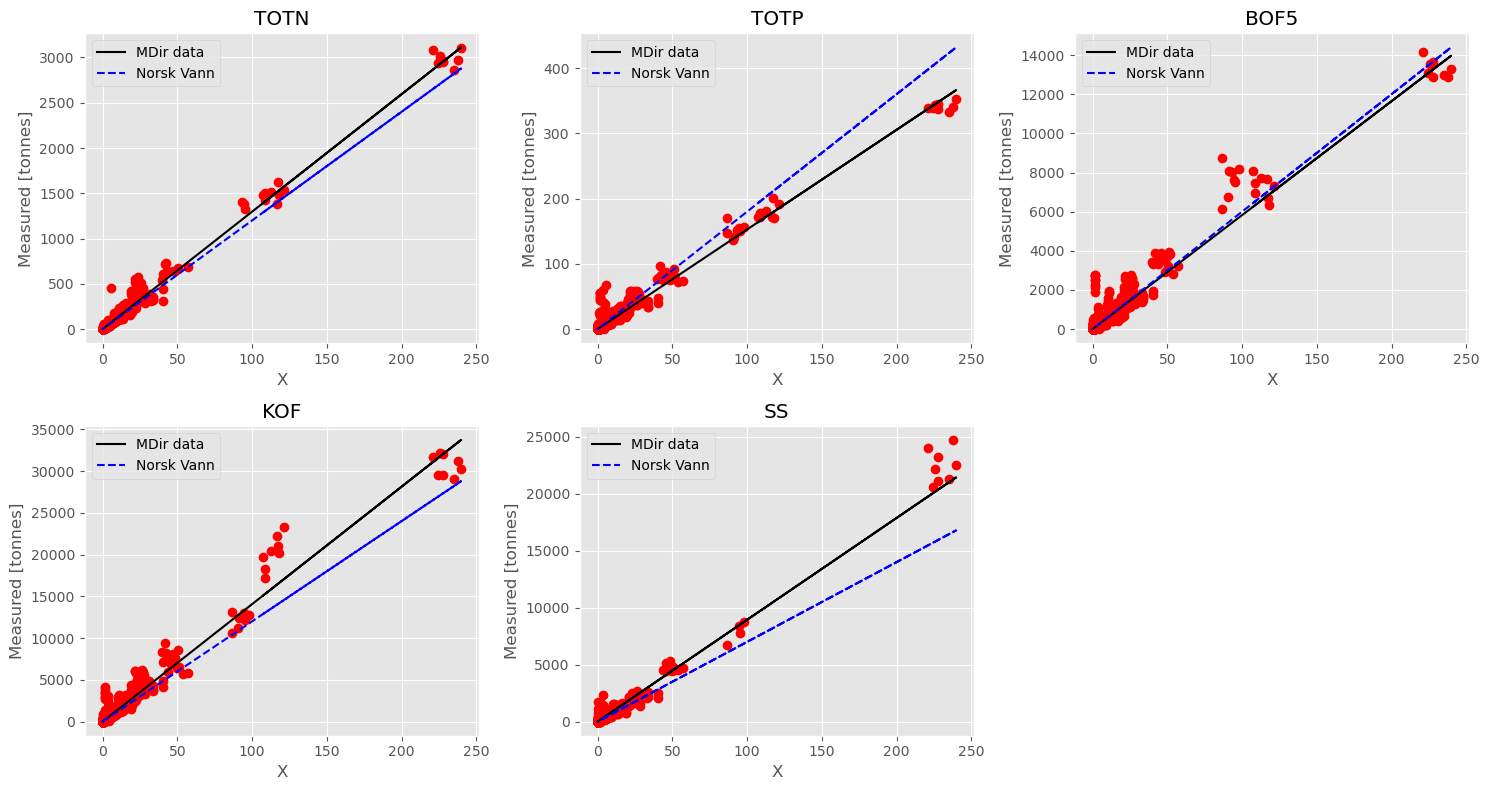

In [17]:
# Get data for comparison
comp_df = df.query(
    "(method == 'Målt') and "
    "(year >= 2017) and "  # See e-mail from Torstein 25.08.2025
    "(n_fritid == n_fritid) and "
    "(n_connected == n_connected) and "
    "((n_fritid > 0) or (n_connected > 0))"
).copy()

# Setup plot
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axes = axes.flatten()
fig.delaxes(axes[-1])

for idx, par in enumerate(pers_dict):
    print("\n\n#####################################")
    print(par.upper())
    par_df = comp_df.copy()
    par_df["X"] = (par_df["n_connected"] * 365.25 + comp_df["n_fritid"] * 4 * 60) / 1e6
    par_df = par_df.dropna(subset=[f"{par}_in_tonnes", "X"])

    # Fit robust linear model
    y, X = dmatrices(f"{par}_in_tonnes ~ X - 1", data=par_df, return_type="dataframe")
    model = sm.RLM(y, X, M=sm.robust.norms.HuberT())
    results = model.fit()

    # # Fit standard linear model
    # model = smf.ols(formula=f"{par}_in_tonnes ~ X - 1", data=par_df)
    # results = model.fit()

    # Regression summary
    print(results.summary())
    slp = results.params["X"]
    nv_slp = pers_dict.get(par)
    print(f"\nEstimated coefficient for {par.upper()}: {slp:.1f}.")
    print(f"Norsk Vann coefficient for {par.upper()}: {nv_slp:.1f}.")

    # Plot
    axes[idx].plot(par_df["X"], par_df[f"{par}_in_tonnes"], "ro")
    axes[idx].plot(par_df["X"], slp * par_df["X"], "k-", label="MDir data")
    axes[idx].plot(par_df["X"], pers_dict[par] * par_df["X"], "b--", label="Norsk Vann")
    axes[idx].legend(loc="best")
    axes[idx].set_ylabel("Measured [tonnes]")
    axes[idx].set_xlabel("X")
    axes[idx].set_title(par.upper())
plt.tight_layout()

# Save
png_path = r"estimate_person_factors.png"
plt.savefig(png_path, dpi=200, bbox_inches="tight")

These results suggests the following contributions might be more appropriate than those from Norsk Vann:

 * TOTN: 13 g/pers/day
 * TOTP: 1.5 g/pers/day
 * BOF5: 58 g/pers/day
 * KOF: 141 g/pers/day
 * SS: 89 g/pers/day

Note that the values for KOF and SS are a bit higher than suggested by Norsk Vann, although both sets of values are probably reasonable.

In an e-mail received 25.08.2025, Torstein noted that values estimated from the data in this way will include additional inputs from e.g. industrial sites connected to the municipal network. This may help to explain why my estimates are generally a bit higher than those from Norsk Vann (although then the result for TOTP seems strange).

**For TEOTIL3, I will use the values from Norsk Vann, since they are generally accepted and seem reasonable given other uncertainties.**

### 3.5. Estimate renseeffekter from data

We can also use MDir's data to estimate reported treatment efficiencies. These can be compared to the default values suggested by Torstein (see above).

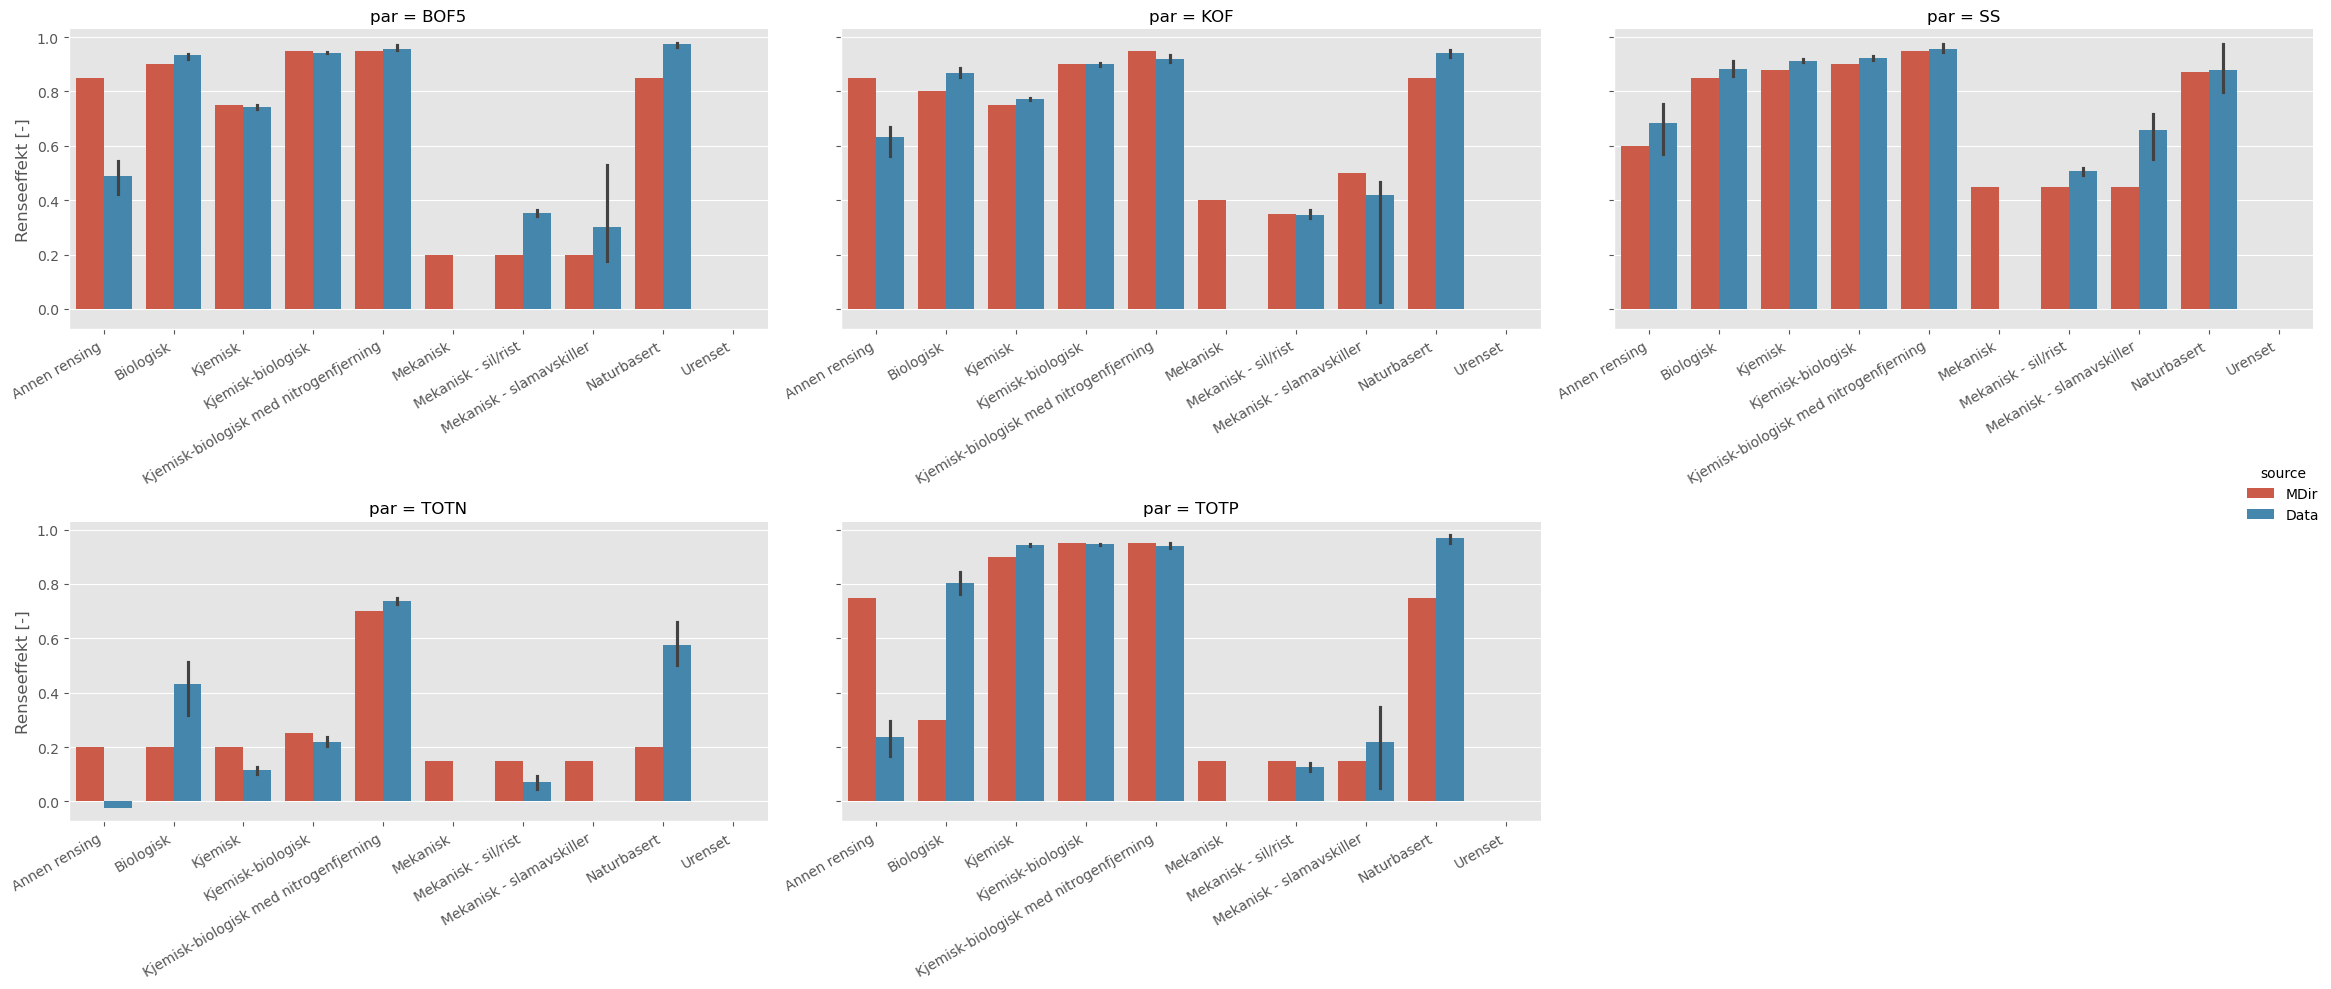

In [18]:
# Renseeffekter for each par and site type estimated from measured data
cols = [
    "anlegg_nr",
    "year",
    "type",
    "method",
    "bof5_in_tonnes",
    "kof_in_tonnes",
    "totn_in_tonnes",
    "totp_in_tonnes",
    "ss_in_tonnes",
    "bof5_out_tonnes",
    "kof_out_tonnes",
    "totn_out_tonnes",
    "totp_out_tonnes",
    "ss_out_tonnes",
]
eff_df_est = df[cols].query("method == 'Målt'").copy()

# Calculate renseeffekter
pars = ["bof5", "kof", "totn", "totp", "ss"]
for par in pars:
    eff_df_est[f"{par}_ren_eff_est"] = 1 - (
        eff_df_est[f"{par}_out_tonnes"] / eff_df_est[f"{par}_in_tonnes"]
    )
    del eff_df_est[f"{par}_in_tonnes"], eff_df_est[f"{par}_out_tonnes"]
eff_df_est = eff_df_est.drop(columns=["anlegg_nr", "year", "method"])

# Convert both MDir defaults and estimates to long format
eff_df_est_long = eff_df_est.melt(id_vars="type").dropna()
eff_df_est_long["source"] = "Data"
eff_df_long = eff_df.drop(columns="teotil_type").melt(id_vars="type").dropna()
eff_df_long["source"] = "MDir"

# Combine
eff_df_long = pd.concat([eff_df_long, eff_df_est_long], axis="rows")
eff_df_long["par"] = (
    eff_df_long["variable"].str.split("_", expand=True, n=1)[0].str.upper()
)
del eff_df_long["variable"]
eff_df_long = eff_df_long.reset_index(drop=True)

# Plot
g = sn.catplot(
    data=eff_df_long,
    x="type",
    y="value",
    hue="source",
    col="par",
    col_wrap=3,
    kind="bar",
    estimator="median",
    errorbar=("ci", 95),
    sharex=False,
    sharey=True,
    aspect=1.5,
    col_order=["BOF5", "KOF", "SS", "TOTN", "TOTP"],
)
g.set(xlabel="")
for ax in g.axes.flat:
    ax.set_ylabel("Renseeffekt [-]")
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
plt.tight_layout()

# Save
png_path = r"estimated_renseeffekter_large_sites.png"
plt.savefig(png_path, dpi=200, bbox_inches="tight")

The factors used by MDir look reasonable in most cases. Perhaps the most notable difference is that MDir’s treatment efficiencies for TOTN and TOTP for "Biologisk" plants seem low. However, some of my estimates are based on data from just a few sites, so they might not be truly representative. **In TEOTIL3, I will use the values recommended by Torstein for compatibility with MDir’s workflow**.

### 3.6. Fill data gaps

We need a complete set of input data for BOF5, SS, TOTN and TOTP for each site. For KOF, I will use the measured data (and MDir's estimated values, where available). However, I will not patch gaps for KOF and will use estimated BOF5 instead. The reason for this is that TEOTIL3 uses KOF in preference to BOF5, because KOF is "closer" to TOC. If I estimate values for KOF, there may therefore be cases where the model chooses to use *estimated* KOF instead of *measured* BOF5, which is undesirable. Estimates of BOF5 and KOF based on the number of people connected are likely to be equally approximate, so I don't think there's a strong argument to prefer estimated KOF over estimated BOF5. However, I want to use measured values where available.

For consistency, gaps are patched sequentially, as described below. For BOF5, SS, TOTN and TOTP:

 1. **Case 1: Inflow and outflow are both known (either measured directly or estimated by MDir)**

    Values from MDir's database are assumed to be correct. The "true" renseeffekt can be estimated from the reported inflows and outflows.
    
 2. **Case 2: Inflow is known, outflow is NaN**

    If the input is known but the output is not, the output is calculated using typical renseeffekter for each site type (Section 3.2).

 3. **Case 3: Inflow is NaN, outflow is known**

    If the outflow is known but the inflow is not, the inflow is calculated using typical renseeffekter for each site type (Section 3.2).

 4. **Case 4: Inflow and outflow are both NaN**
    
    If the inflow and outflow are both NaN, but `n_fritid` and/or `n_connected` are known, the input is estimated from the number of people/households connected using the formula given in Section 3.4. The outflow is then calculated from the estimated inflow by assuming a typical renseeffekter based on the site type (Section 3.2).

Patching in this order prioritises measured data and gives the most consistent results.

In [19]:
# Create a single dataset from MDir's data. Assume values here are correct
cols = [
    "anlegg_nr",
    "type",
    "year",
    "n_fritid",
    "n_connected",
    "bof5_in_tonnes",
    "kof_in_tonnes",
    "totn_in_tonnes",
    "totp_in_tonnes",
    "ss_in_tonnes",
    "bof5_out_tonnes",
    "kof_out_tonnes",
    "totn_out_tonnes",
    "totp_out_tonnes",
    "ss_out_tonnes",
]
mdir_df = df[cols].copy()

# Check for NaNs
cols = ["type", "n_fritid", "n_connected"]
for col in cols:
    if mdir_df[col].isna().sum() > 0:
        raise ValueError(f"NaNs are present in column '{col}'.")

# Combine measured and estimated values from MDir (assume both are OK)
mdir_df = mdir_df.groupby(["anlegg_nr", "type", "year"]).mean().reset_index()

# Join default renseeffekter
mdir_df = pd.merge(mdir_df, eff_df.drop(columns="teotil_type"), how="left", on="type")

print(len(mdir_df), "rows in the dataset.")

for par, per_val in pers_dict.items():
    if par == "kof":
        # Do not patch KOF - see text above for explanation
        continue
    print("\n###########################")
    print(par.upper())

    print("\nCASE 1: Inflow and outflow both known.\nOK.")

    print("\nCASE 2: Inflow known; outflow NaN.")
    print("Estimating outflows from inflows.")
    mdir_df[f"{par}_out_est_tonnes"] = mdir_df[f"{par}_in_tonnes"] * (
        1 - mdir_df[f"{par}_eff_pct"]
    )
    n_vals0 = mdir_df[f"{par}_out_tonnes"].count()
    mdir_df[f"{par}_out_tonnes"] = mdir_df[f"{par}_out_tonnes"].fillna(
        mdir_df[f"{par}_out_est_tonnes"]
    )
    del mdir_df[f"{par}_out_est_tonnes"]
    n_vals1 = mdir_df[f"{par}_out_tonnes"].count()
    print(f"Before filling: {n_vals0} non-NaN values.")
    print(f"After filling:  {n_vals1} non-NaN values.")

    print("\nCASE 3: Inflow NaN; outflow known.")
    print("Estimating inflows from outflows.")
    mdir_df[f"{par}_in_est_tonnes"] = mdir_df[f"{par}_out_tonnes"] / (
        1 - mdir_df[f"{par}_eff_pct"]
    )
    n_vals0 = mdir_df[f"{par}_in_tonnes"].count()
    mdir_df[f"{par}_in_tonnes"] = mdir_df[f"{par}_in_tonnes"].fillna(
        mdir_df[f"{par}_in_est_tonnes"]
    )
    del mdir_df[f"{par}_in_est_tonnes"]
    n_vals1 = mdir_df[f"{par}_in_tonnes"].count()
    print(f"Before filling: {n_vals0} non-NaN values.")
    print(f"After filling:  {n_vals1} non-NaN values.")

    print("\nCASE 4: Inflow NaN; outflow NaN.")
    print("Estimating inflows from 'n_connected' and 'n_fritid'.")
    mdir_df[f"{par}_in_est_tonnes"] = (
        mdir_df["n_connected"] * per_val * 365.25
        + mdir_df["n_fritid"] * per_val * 4 * 60
    ) / 1e6
    mdir_df[f"{par}_in_est_tonnes"] = mdir_df[f"{par}_in_est_tonnes"].replace(0, np.nan)
    n_vals0 = mdir_df[f"{par}_in_tonnes"].count()
    mdir_df[f"{par}_in_tonnes"] = mdir_df[f"{par}_in_tonnes"].fillna(
        mdir_df[f"{par}_in_est_tonnes"]
    )
    del mdir_df[f"{par}_in_est_tonnes"]
    n_vals1 = mdir_df[f"{par}_in_tonnes"].count()
    print(f"Before filling: {n_vals0} non-NaN values.")
    print(f"After filling:  {n_vals1} non-NaN values.")

    print("Calculating outflows from estimated inflows.")
    mdir_df[f"{par}_out_est_tonnes"] = mdir_df[f"{par}_in_tonnes"] * (
        1 - mdir_df[f"{par}_eff_pct"]
    )
    n_vals0 = mdir_df[f"{par}_out_tonnes"].count()
    mdir_df[f"{par}_out_tonnes"] = mdir_df[f"{par}_out_tonnes"].fillna(
        mdir_df[f"{par}_out_est_tonnes"]
    )
    del mdir_df[f"{par}_out_est_tonnes"]
    n_vals1 = mdir_df[f"{par}_out_tonnes"].count()
    print(f"Before filling: {n_vals0} non-NaN values.")
    print(f"After filling:  {n_vals1} non-NaN values.")

# Drop unnecessary cols
cols = [col for col in mdir_df.columns if col.endswith("_eff_pct")] + [
    "n_fritid",
    "n_connected",
    "type",
]
mdir_df = mdir_df.drop(columns=cols)

# Only keep rows with at least some data
cols = [col for col in mdir_df.columns if col.endswith("_tonnes")]
all_nan_df = mdir_df[mdir_df[cols].isna().all(axis="columns")][["anlegg_nr", "year"]]
mdir_df = mdir_df.dropna(subset=cols, how="all")
if len(all_nan_df) > 0:
    print(
        "\nWARNING: The following site-years have no discharge data at all. "
        "These rows cannot be gap-filled and will be dropped."
    )
    print(all_nan_df)

mdir_df.head()

23106 rows in the dataset.

###########################
TOTN

CASE 1: Inflow and outflow both known.
OK.

CASE 2: Inflow known; outflow NaN.
Estimating outflows from inflows.
Before filling: 19816 non-NaN values.
After filling:  20101 non-NaN values.

CASE 3: Inflow NaN; outflow known.
Estimating inflows from outflows.
Before filling: 19988 non-NaN values.
After filling:  20101 non-NaN values.

CASE 4: Inflow NaN; outflow NaN.
Estimating inflows from 'n_connected' and 'n_fritid'.
Before filling: 20101 non-NaN values.
After filling:  23048 non-NaN values.
Calculating outflows from estimated inflows.
Before filling: 20101 non-NaN values.
After filling:  23048 non-NaN values.

###########################
TOTP

CASE 1: Inflow and outflow both known.
OK.

CASE 2: Inflow known; outflow NaN.
Estimating outflows from inflows.
Before filling: 22410 non-NaN values.
After filling:  22680 non-NaN values.

CASE 3: Inflow NaN; outflow known.
Estimating inflows from outflows.
Before filling: 22512 no

,anlegg_nr,year,bof5_in_tonnes,kof_in_tonnes,totn_in_tonnes,totp_in_tonnes,ss_in_tonnes,bof5_out_tonnes,kof_out_tonnes,totn_out_tonnes,totp_out_tonnes,ss_out_tonnes
0,0301.0979.01,2010,7378.308128,18562.913291,1328.249,179.177478,6968.013045,526.710061,1461.364028,407.903,8.958874,348.400652
1,0301.0979.01,2011,7808.765696,21736.681119,1449.410,166.855000,7256.849092,574.262503,2845.252931,479.505,17.143000,362.842455
2,0301.0979.01,2012,6617.020000,21146.080000,1452.467,171.102000,7530.421342,323.644000,1809.760000,412.180,11.191000,376.521067
3,0301.0979.01,2013,7532.404000,19336.600000,1389.500,170.100000,7744.676992,351.872800,1745.560000,435.000,7.140000,387.233850
4,0301.0979.01,2014,7031.698239,21407.565445,1489.600,174.400000,7644.171150,548.827537,2968.005254,433.000,15.180000,382.208558


In [20]:
# Check data completeness
# We always need inputs and outputs for SS, TOTN and TOTP
req_cols = [
    "ss_in_tonnes",
    "ss_out_tonnes",
    "totn_in_tonnes",
    "totn_out_tonnes",
    "totp_in_tonnes",
    "totp_out_tonnes",
]
req_complete = mdir_df[req_cols].notnull().all(axis=1)

# We also need *either* complete data for BOF5 or complete data for KOF, but not both
bof5_complete = mdir_df[["bof5_in_tonnes", "bof5_out_tonnes"]].notnull().all(axis=1)
kof_complete = mdir_df[["kof_in_tonnes", "kof_out_tonnes"]].notnull().all(axis=1)

# Combine criteria
mdir_df["complete"] = ((bof5_complete | kof_complete) & req_complete).astype(int)

# Estimate number of site-years with sufficient data for scenarios estimation
pct_complete = 100 * mdir_df["complete"].sum() / len(mdir_df)
print(f"Complete data for {pct_complete:.1f}% of site-years.")

# Filter to only 'complete' records
mdir_df = mdir_df.query("complete == 1").drop(columns="complete")

Complete data for 99.7% of site-years.


The methodology above creates a near-complete dataset for all sites with at least one measurement in one year (i.e. a site that has at least one inflow or outflow value in MDir's database). Next, I could use **statistical imputation** to patch the remaining 0.3% of site-years, but this seems unnecessarily complicated: TEOTIL3 is a simple model and for the sake of transparency I want to avoid excessive data cleaning or statistical manipulation. Instead, I will simply drop (ignore) the 0.3% of site years with incomplete data.

### 3.7. Interpolate missing data

Some sites report data in one year, and then do not appear at all in MDir's dataset until later. I would expect these sites to be included in MDir's "estimated" values, but in many cases they are not. In SSB's dataset, Gisle has filled these gaps, but I'm not sure how this has been done.

In the code below, I generate complete annual time series for each site from 2013 to 2024, padded with NaNs as necessary. I then **linearly interpolate missing data, but without extrapolation**. For example, if a site appears in MDir's dataset in 2015, and then again in 2020, I assume the site has been active from 2015 to 2020 and interpolate values for the missing years. However, I do not estimate any values before 2015 or after 2020.

In [21]:
# Combine data and site properties
cols = [
    "anlegg_nr",
    "kilderefnr",
    "anlegg_name",
    "activity",
    "kommune",
    "fylke",
    "site_utm_zone",
    "site_east",
    "site_north",
    "outflow_utm_zone",
    "outflow_east",
    "outflow_north",
    "capacity",
    "n_fritid",
    "n_connected",
    "type",
    "year",
    "bof5_in_tonnes",
    "bof5_out_tonnes",
    "kof_in_tonnes",
    "kof_out_tonnes",
    "ss_in_tonnes",
    "ss_out_tonnes",
    "totn_in_tonnes",
    "totn_out_tonnes",
    "totp_in_tonnes",
    "totp_out_tonnes",
]
df = pd.merge(mdir_df, prop_df, on=["year", "anlegg_nr"], how="left")
df = pd.merge(df, site_df, on="anlegg_nr", how="left")
df = (
    df[cols]
    .sort_values(by=["anlegg_nr", "year"], ascending=True)
    .reset_index(drop=True)
)

# Some site-years are missing metadata. Patch with info from the same site in other years, if possible
cols = [
    "anlegg_name",
    "kilderefnr",
    "activity",
    "kommune",
    "fylke",
    "site_utm_zone",
    "site_east",
    "site_north",
    "outflow_utm_zone",
    "outflow_east",
    "outflow_north",
    "capacity",
    "n_fritid",
    "n_connected",
    "type",
]
df[cols] = df.groupby("anlegg_nr")[cols].ffill().bfill()
for col in cols:
    if df[col].isna().sum() > 0:
        raise ValueError(f"Could not patch NaNs for column '{col}'.")

In [22]:
# Get combination of sites and all years
years = list(range(df["year"].min(), df["year"].max()))
anlegg_ids = df["anlegg_nr"].unique()
full_index = pd.MultiIndex.from_product(
    [anlegg_ids, years], names=["anlegg_nr", "year"]
)

# Reindex to include all combinations
df = df.set_index(["anlegg_nr", "year"])
df = df.reindex(full_index).reset_index()

xl_path = r"/home/jovyan/shared/common/teotil3/point_data/raw_data_delivered_2025/mdir_wastewater_data/before_interp.xlsx"
df.to_excel(xl_path, index=False)

# Interpolate data gaps for inflows and outflows
cols = [
    col for col in df.columns if col.endswith("_tonnes") and not col.startswith("kof")
]
df[cols] = df.groupby("anlegg_nr")[cols].transform(
    lambda group: group.interpolate(method="linear", limit_area="inside")
)

# Interpolate data gaps for capacity and number connected
cols = ["capacity", "n_fritid", "n_connected"]
df[cols] = df.groupby("anlegg_nr")[cols].transform(
    lambda group: (
        group.interpolate(method="linear", limit_area="inside").ffill().bfill().round()
    )
)

# Fill gaps in other columns
cols = [
    "anlegg_name",
    "kilderefnr",
    "activity",
    "kommune",
    "fylke",
    "site_utm_zone",
    "site_east",
    "site_north",
    "outflow_utm_zone",
    "outflow_east",
    "outflow_north",
    "type",
]
df[cols] = df.groupby("anlegg_nr")[cols].ffill().bfill()

# Drop empty rows
cols = [col for col in df.columns if col.endswith("_tonnes")]
df = df.dropna(subset=cols, how="all")

# Check metadata
cols = [
    "anlegg_name",
    "kilderefnr",
    "activity",
    "kommune",
    "fylke",
    "site_utm_zone",
    "site_east",
    "site_north",
    "outflow_utm_zone",
    "outflow_east",
    "outflow_north",
    "type",
    "capacity",
    "n_fritid",
    "n_connected",
]
for col in cols:
    if df[col].isna().sum() > 0:
        raise ValueError(f"Could not patch NaNs for column '{col}'.")

xl_path = r"/home/jovyan/shared/common/teotil3/point_data/raw_data_delivered_2025/mdir_wastewater_data/after_interp.xlsx"
df.to_excel(xl_path, index=False)

In [23]:
# Filter to just data from 2013-23
df = df.query("(year >= 2013) and (year <= 2023)")
df["n_fritid"] = df["n_fritid"].fillna(0)

# Save all data for checking
xl_path = r"/home/jovyan/shared/common/teotil3/point_data/raw_data_delivered_2025/mdir_wastewater_data/cleaned_patched_data_2013-2023.xlsx"
df.to_excel(xl_path, index=False)

# Save annual files for TEOTIL3
for year in range(2013, 2024):
    ann_df = df.query("year == @year").copy()
    xl_path = f"/home/jovyan/shared/common/teotil3/point_data/{year}/avlop_stor_anlegg_{year}_raw_new.xlsx"
    ann_df.to_excel(xl_path, index=False)

df.head()

,anlegg_nr,year,kilderefnr,anlegg_name,activity,kommune,fylke,site_utm_zone,site_east,site_north,...,bof5_in_tonnes,bof5_out_tonnes,kof_in_tonnes,kof_out_tonnes,ss_in_tonnes,ss_out_tonnes,totn_in_tonnes,totn_out_tonnes,totp_in_tonnes,totp_out_tonnes
3,0301.0979.01,2013,0301AL01,Bekkelaget renseanlegg med tilførselstuneller ...,Avløpsnett og -rensing,Oslo,Oslo,32.0,599070.0,6639810.0,...,7532.404000,351.872800,19336.600000,1745.560000,7744.676992,387.233850,1389.500000,435.000000,170.100000,7.140000
4,0301.0979.01,2014,0301AL01,Bekkelaget renseanlegg med tilførselstuneller ...,Avløpsnett og -rensing,Oslo,Oslo,32.0,599070.0,6639810.0,...,7031.698239,548.827537,21407.565445,2968.005254,7644.171150,382.208558,1489.600000,433.000000,174.400000,15.180000
5,0301.0979.01,2015,0301AL01,Bekkelaget renseanlegg med tilførselstuneller ...,Avløpsnett og -rensing,Oslo,Oslo,32.0,599070.0,6639810.0,...,7835.118227,794.945842,21594.022051,2946.287589,7518.302347,375.915117,1534.000000,387.300000,175.400000,14.400000
6,0301.0979.01,2016,0301AL01,Bekkelaget renseanlegg med tilførselstuneller ...,Avløpsnett og -rensing,Oslo,Oslo,32.0,599070.0,6639810.0,...,7035.436986,135.825424,17840.463377,1194.844450,7529.577615,376.478881,1438.000000,382.800000,168.100000,10.220000
7,0301.0979.01,2017,0301AL01,Bekkelaget renseanlegg med tilførselstuneller ...,Avløpsnett og -rensing,Oslo,Oslo,32.0,599070.0,6639810.0,...,8063.605109,98.983795,19753.086471,1073.030207,7515.890200,375.794510,1484.843723,398.429075,171.452972,13.763257


### 3.8. Compare to data from Gisle/SSB

Compare the new estimates to data previously delivered by Gisle Berge at SSB.

In [24]:
# Read data from SSB/Gisle
df_list = []
for year in range(2013, 2024):
    xl_path = f"/home/jovyan/shared/common/teotil3/point_data/{year}/avlop_stor_anlegg_{year}_raw.xlsx"
    ssb_df = pd.read_excel(xl_path, sheet_name=f"store_anlegg_{year}")
    df_list.append(ssb_df)
ssb_df = pd.concat(df_list, axis="rows")

# Convert units
for col in ["MENGDE_P_INN_kg", "MENGDE_P_UT_kg", "MENGDE_N_INN_kg", "MENGDE_N_UT_kg"]:
    ssb_df[col] = ssb_df[col] / 1000

# Match names to new data
names_dict = {
    "ANLEGGSNR": "kilderefnr",
    "ANLEGGSNAVN": "anlegg_name",
    "year": "year",
    "MENGDE_P_INN_kg": "totp_in_tonnes",
    "MENGDE_P_UT_kg": "totp_out_tonnes",
    "MENGDE_N_INN_kg": "totn_in_tonnes",
    "MENGDE_N_UT_kg": "totn_out_tonnes",
}
ssb_df = ssb_df.rename(columns=names_dict)[names_dict.values()]
ssb_df.head()

,kilderefnr,anlegg_name,year,totp_in_tonnes,totp_out_tonnes,totn_in_tonnes,totn_out_tonnes
0,0101AL02,Bakke,2013,0.1361,0.00780,1.3615,1.02113
1,0101AL06,Kornsjø,2013,0.1215,0.00810,1.5390,0.43800
2,0101AL07,Remmendalen,2013,16.7879,1.92720,124.2973,91.18080
3,0101AL07,Remmendalen,2013,16.7879,1.92720,124.2973,91.18080
4,0104AL01,Kambo,2013,8.1650,0.45625,78.1100,72.27000


In [25]:
# Join SSB data to new estimates
cols = [
    "anlegg_nr",
    "kilderefnr",
    "anlegg_name",
    "year",
    "totp_in_tonnes",
    "totp_out_tonnes",
    "totn_in_tonnes",
    "totn_out_tonnes",
]
new_df = df[cols].copy()
comp_df = pd.merge(
    ssb_df, new_df, how="outer", on=["kilderefnr", "year"], suffixes=("_ssb", "_new")
)
cols = [
    "anlegg_nr",
    "kilderefnr",
    "anlegg_name_ssb",
    "anlegg_name_new",
    "year",
    "totp_in_tonnes_ssb",
    "totp_in_tonnes_new",
    "totp_out_tonnes_ssb",
    "totp_out_tonnes_new",
    "totn_in_tonnes_ssb",
    "totn_in_tonnes_new",
    "totn_out_tonnes_ssb",
    "totn_out_tonnes_new",
]
comp_df = comp_df[cols]

# Save
xl_path = r"/home/jovyan/shared/common/teotil3/point_data/raw_data_delivered_2025/mdir_wastewater_data/ssb_vs_new.xlsx"
comp_df.to_excel(xl_path, index=False)

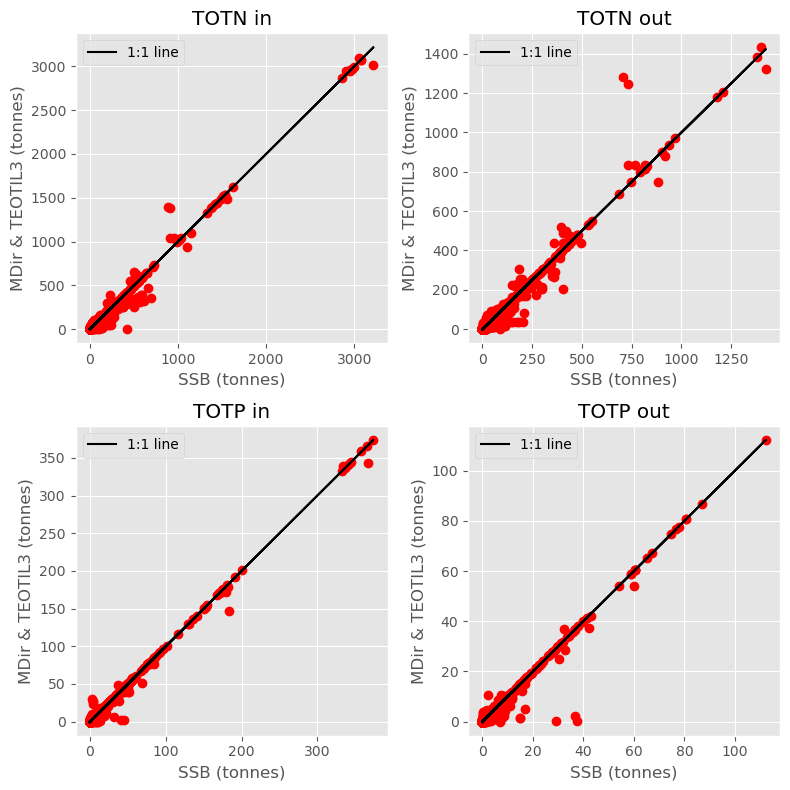

In [26]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
for col_idx, par in enumerate(["totn", "totp"]):
    for row_idx, dir in enumerate(["in", "out"]):
        axes[col_idx, row_idx].plot(
            comp_df[f"{par}_{dir}_tonnes_ssb"], comp_df[f"{par}_{dir}_tonnes_new"], "ro"
        )
        axes[col_idx, row_idx].plot(
            comp_df[f"{par}_{dir}_tonnes_ssb"],
            comp_df[f"{par}_{dir}_tonnes_ssb"],
            "k-",
            label="1:1 line",
        )
        axes[col_idx, row_idx].set_xlabel("SSB (tonnes)")
        axes[col_idx, row_idx].set_ylabel("MDir & TEOTIL3 (tonnes)")
        axes[col_idx, row_idx].set_title(f"{par.upper()} {dir}")
        axes[col_idx, row_idx].legend(loc="best")
        # axes[col_idx, row_idx].set_xscale("log")
        # axes[col_idx, row_idx].set_yscale("log")
plt.tight_layout()

In [27]:
# Compare annual totals
ann_tot_df = comp_df.groupby("year").sum()
for par in ("totn", "totp"):
    for dir in ("in", "out"):
        avg_pct = (
            100
            * ann_tot_df[f"{par}_{dir}_tonnes_new"]
            / ann_tot_df[f"{par}_{dir}_tonnes_ssb"]
        )
        print("\n", par.upper(), dir.upper(), avg_pct)


 TOTN IN year
2013     79.503757
2014     79.111378
2015     87.546282
2016     90.215644
2017     92.645459
2018     97.455863
2019     97.145126
2020     93.862261
2021    100.605367
2022     99.209294
2023     98.266424
dtype: float64

 TOTN OUT year
2013     76.119414
2014     76.374879
2015     86.024685
2016     94.196023
2017     93.635703
2018     98.627772
2019     98.133811
2020     94.431549
2021    103.388820
2022    101.407697
2023     99.534328
dtype: float64

 TOTP IN year
2013    76.744445
2014    78.058007
2015    90.273838
2016    96.034142
2017    92.135408
2018    98.942020
2019    99.632582
2020    98.853752
2021    98.926277
2022    97.500191
2023    97.196591
dtype: float64

 TOTP OUT year
2013    40.977986
2014    41.999391
2015    71.658292
2016    88.118653
2017    88.815991
2018    97.911616
2019    97.991375
2020    96.605094
2021    96.595191
2022    94.873871
2023    93.596439
dtype: float64
